In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.dummy import DummyClassifier
warnings.filterwarnings("ignore")

# Get data & split into train/test/validation sets

In [116]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
df = df.drop(["Area", "AreaSE", "AreaWorst", "Perimeter", "PerimeterSE", "PerimeterWorst"], axis = 1)
encoder = LabelEncoder().fit(df["B/M"])
df['B/M'] = encoder.transform(df["B/M"])
not_data = ["ID", "B/M"]
label = df["B/M"]
feature = df.drop(not_data, axis = 1)
data = pd.concat([label, feature], axis=1)

# Split into train / validation / test sets

In [117]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.25, stratify=label, random_state=0 )
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

# Create & Train Initial Model

Our initial model that we train, before hyperparameter tuning. We want a higher Recall, as it accounts for false negatives - and gives us a lower proportion of them, which we desire. We get a very high accuracy and recall and precision - which makes me suspect of overfitting, especially because we have such a small sample size respective to the number of features.

In [118]:
rfc = RandomForestClassifier(random_state=0, n_estimators=10)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_val)

def bench_marks(y_test, y_pred):
    #print(classification_report(y_test, y_pred))
    #print(confusion_matrix(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')

bench_marks(y_val, y_pred)

Accuracy: 0.9532710280373832
Recall: 0.875
Precision: 1.0


# Feature Selection
Determine importance of each feature, and use recursive feature elimination to determine how many of our features to keep. Then adjust our feature set.

In [119]:
feature_scores = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(feature_scores)
feature_scores = feature_scores.index.tolist()

y_pred = rfc.predict(x_val)
bench_marks(y_val, y_pred)

rfecv = RFECV(estimator=rfc, step=1, cv=5,scoring='accuracy')
rfecv = rfecv.fit(x_train, y_train)
print(rfecv.n_features_)
print(x_train.columns[rfecv.support_])
feature_select = feature[x_train.columns[rfecv.support_]]

x_train, x_test, y_train, y_test = train_test_split(feature_select, label, test_size=0.25, stratify=label, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

Concavity                0.266643
RadiusWorst              0.265244
Compactness              0.098289
ConcavePointsWorst       0.085100
ConcavityWorst           0.038490
ConcavePoints            0.034376
RadiusSE                 0.029479
Symmetry                 0.028937
TextureWorst             0.022751
FractalDimensionSE       0.019173
Radius                   0.016902
Smoothness               0.011944
FractalDimensionWorst    0.011915
SmoothnessWorst          0.011852
ConcavitySE              0.010010
CompactnessSE            0.009813
Texture                  0.009120
SmoothnessSE             0.007074
SymmetrySE               0.007022
FractalDimension         0.007004
SymmetryWorst            0.005676
CompactnessWorst         0.001140
TextureSE                0.001110
ConcavePointsSE          0.000933
dtype: float64
Accuracy: 0.9532710280373832
Recall: 0.875
Precision: 1.0
9
Index(['Radius', 'Smoothness', 'Concavity', 'ConcavePoints', 'RadiusSE',
       'RadiusWorst', 'TextureWorst'

# Hyperparameter Tuning

We will use a random grib with a randomized search to try different iterations of the trees and brute force our way to a optimal solution. We will repeat the code below, adjusting the parameters each iteration. Iterate by running this code while changing values in first box.

In [127]:
n_estimators = [int(x) for x in range(100,300,5)]
max_depth = [int(x) for x in np.linspace(200, 400, num = 5)]
max_features = ["sqrt", "log2", None]
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf = [1, 4, 7, 9, 10, 11, 12]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [128]:
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 200, cv = 3, verbose=2, random_state=0, n_jobs = -1)
rf_random.fit(x_train, y_train)
rfc = rf_random.best_estimator_

#validation set
y_pred = rfc.predict(x_val)
print(rf_random.best_estimator_)
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'Recall: {recall_score(y_val, y_pred)}')
print(f'Precision: {precision_score(y_val, y_pred)}')
print("\n")
#actual test set
y_real_pred = rfc.predict(x_test)
print("For actual test set we get:")
print(f'Accuracy: {accuracy_score(y_test, y_real_pred)}')
print(f'Recall: {recall_score(y_test, y_real_pred)}')
print(f'Precision: {precision_score(y_test, y_real_pred)}')



Fitting 3 folds for each of 200 candidates, totalling 600 fits
RandomForestClassifier(bootstrap=False, max_depth=250, max_features='log2',
                       min_samples_leaf=11, min_samples_split=5,
                       n_estimators=155, random_state=0)
Accuracy: 0.9626168224299065
Recall: 0.975
Precision: 0.9285714285714286


For actual test set we get:
Accuracy: 0.9440559440559441
Recall: 0.9811320754716981
Precision: 0.8813559322033898


# Test for over/ underfitting

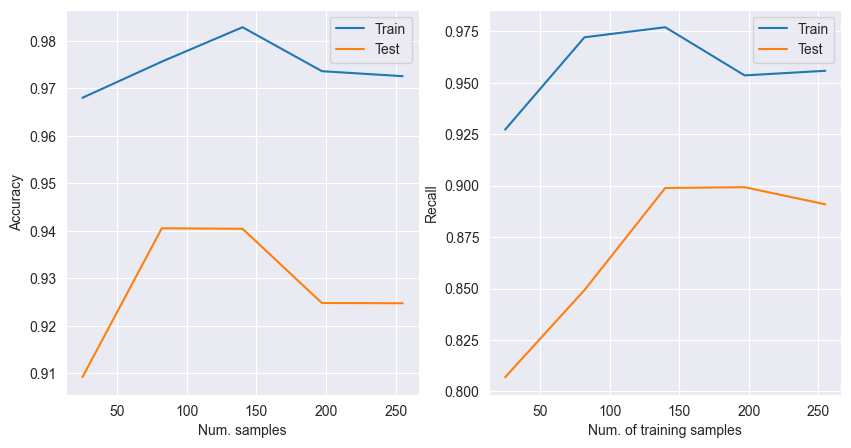

In [126]:
train_sizes_abs_accuracy, train_accuracy, test_accuracy = learning_curve(estimator=rfc, X=x_train, y=y_train, scoring='accuracy', cv=5)

train_sizes_abs_error, train_error, test_error = learning_curve(estimator=rfc, X=x_train, y=y_train, scoring='recall', cv=5)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
train_avg_accuracy, test_avg_accuracy, train_avg_error, test_avg_error = [], [], [], []

for i in range(len(train_sizes_abs_accuracy)):
    train_avg_accuracy.append(np.average(train_accuracy[i]))
    test_avg_accuracy.append(np.average(test_accuracy[i]))

for i in range(len(train_sizes_abs_error)):
    train_avg_error.append(np.average(train_error[i]))
    test_avg_error.append(np.average(test_error[i]))

# Accuracy learning curve
ax[0].plot(train_sizes_abs_accuracy, train_avg_accuracy)
ax[0].plot(train_sizes_abs_accuracy, test_avg_accuracy)
ax[0].legend(['Train', 'Test'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Num. samples')

# Error learning curve
ax[1].plot(train_sizes_abs_error, train_avg_error)
ax[1].plot(train_sizes_abs_error, test_avg_error)
ax[1].legend(['Train', 'Test'])
ax[1].set_xlabel('Num. of training samples')
ax[1].set_ylabel('Recall')
plt.show()

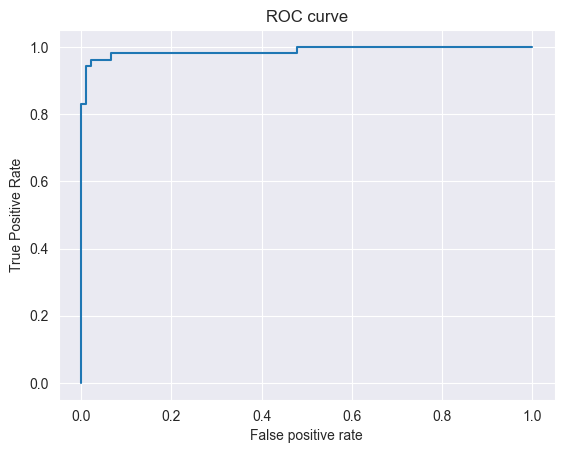

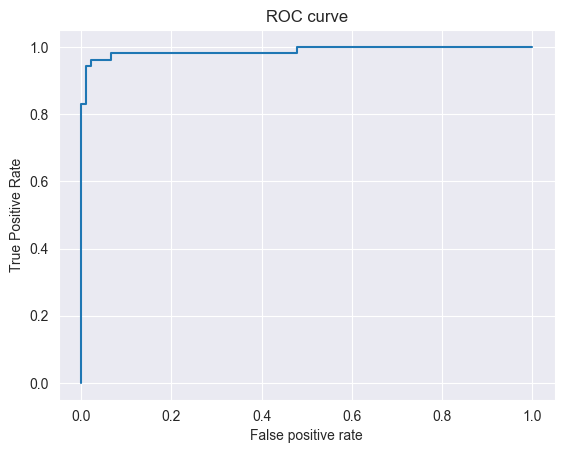

In [101]:
# After hyperparameter tuning* and feature selection*
y_real_pred = rfc.predict(x_test)
auc = roc_auc_score(y_test, y_real_pred)

y_pred_prob = rfc.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
plt.show()


We want to minimise false positives..

How does this graph help us? IG I could manually calculate (using the graph) the precesion, accuracy and  recall stats to determine which point is best.

In [105]:
dm = DummyClassifier()
dm.fit(x_train, y_train)
dummy_score = dm.score(x_test, y_test)
y_pred = rfc.predict(x_test)  # Model classifications
accuracy = accuracy_score(y_test, y_pred)

print(f'{"Our model beats the dummy model" if accuracy > dummy_score else "Our model does not beat the dummy model."}')

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Smoothness
